In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk. stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
fake_news = pd.read_csv('fake.csv')
fake_news = fake_news[['title', 'text','site_url']]
fake_news.head()

,title,text,site_url
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup.com
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup.com
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup.com
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup.com
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup.com


In [3]:
fake_news.isnull().sum()

title       680
text         46
site_url      0
dtype: int64

In [4]:
fake_news['site_url'] = fake_news['site_url'].apply(lambda x:x.split('.')[0])

In [5]:
fake_news['title'].fillna("", inplace=True)
fake_news.dropna(inplace=True)
fake_news['type'] = 'fake'
fake_news.columns = ['title','content','publication','type']
fake_news.isnull().sum()

title          0
content        0
publication    0
type           0
dtype: int64

In [6]:
fake_news.head()

,title,content,publication,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [7]:
real_news = pd.read_csv('real.csv')
real_news = real_news[['title', 'content','publication']]
real_news['type'] = 'real'
real_news.columns = ['title','content','publication','type']
real_news.head()

,title,content,publication,type
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


In [8]:
real_news.isnull().sum()

title          0
content        0
publication    0
type           0
dtype: int64

In [9]:
print(fake_news.shape)
print(real_news.shape)

(12953, 4)
(15712, 4)


In [10]:
df = pd.concat([fake_news, real_news])
df.reset_index(drop=True, inplace=True)
df.head()

,title,content,publication,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [11]:
df.shape

(28665, 4)

In [13]:
ps = WordNetLemmatizer()

In [16]:
# text preprocessing
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', str(df['content'][i])) # removing sepcial characters and numbers
    review = review.lower() # lowering the text
    review = review.split() 
    # removing stopwords and lemmatization
    review = [ps.lemmatize(word) for word in review if not word in set(stopwords.words('english'))] 
    review = ' '.join(review)
    corpus.append(review)

all_words = []
for text in corpus:
    all_words.append(text.split())
    
words = [j for i in all_words for j in i]

from nltk.probability import FreqDist
fdist = FreqDist(words)
print(fdist)

<FreqDist with 155186 samples and 12750257 outcomes>


In [17]:
print(fdist.most_common(20))

[('trump', 105130), ('said', 92973), ('u', 62455), ('one', 61050), ('people', 58148), ('would', 57261), ('state', 53469), ('clinton', 51459), ('year', 50367), ('time', 45126), ('new', 41746), ('like', 40292), ('also', 37853), ('say', 36883), ('president', 33160), ('could', 32249), ('election', 32037), ('american', 31438), ('even', 29554), ('many', 28680)]


In [20]:
# Creating the TF-IDF model
cv = TfidfVectorizer(max_features=10000) # shape (28665, 155161)
X = cv.fit_transform(corpus).toarray()

y=pd.get_dummies(df['type'])
y=y.iloc[:,1].values

In [21]:
X.shape

(28665, 10000)

### MultinomialNB

In [46]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [47]:
# Training model using Naive bayes classifier
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

In [24]:
print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.8485958485958486


[[2020  612]
 [ 256 2845]]


              precision    recall  f1-score   support

           0       0.89      0.77      0.82      2632
           1       0.82      0.92      0.87      3101

    accuracy                           0.85      5733
   macro avg       0.86      0.84      0.85      5733
weighted avg       0.85      0.85      0.85      5733



In [26]:
m = MultinomialNB()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(m, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.85071503 0.85176142 0.84931985 0.85943495 0.84827346 0.85833915
 0.84612701 0.85066294 0.8611305  0.85659456]
0.8532358860883198


## Logistic Regression

In [61]:
clf = LogisticRegression(solver='sag').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [62]:
print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.9195883481597767


[[2365  267]
 [ 194 2907]]


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2632
           1       0.92      0.94      0.93      3101

    accuracy                           0.92      5733
   macro avg       0.92      0.92      0.92      5733
weighted avg       0.92      0.92      0.92      5733



In [63]:
logreg = LogisticRegression(solver='sag')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(logreg, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.92256714 0.92396233 0.92884548 0.93617021 0.91942797 0.92951849
 0.93091417 0.92742498 0.91800419 0.93265876]
0.9269493728840663


### ROC AUC Curve

In [70]:
classifiers = [LogisticRegression(solver='sag'), 
               MultinomialNB()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

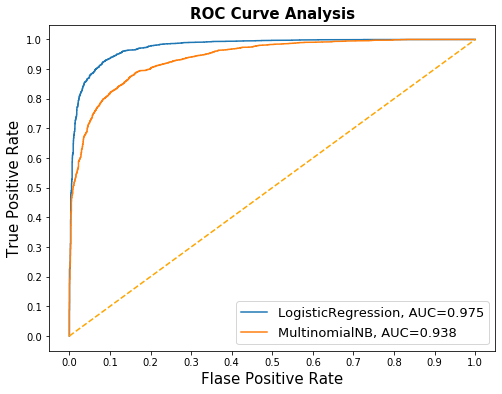

In [71]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()